In [1]:
import sys, os, toml
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, HTML
from itertools import combinations_with_replacement
from torch.utils.data import Dataset, DataLoader

sys.path.append(os.path.join(sys.path[0], '../..'))

from data.kcost_dataset import KCostDataSetSplit, KCostDataSetSplitDF
from data.io import Writer, Reader
from model.kcost import KCostModel
from lsm.cost import EndureQFixedCost, EndureTierLevelCost, EndureKHybridCost
from lsm.lsmtype import LSMTree, LSMSystem, Policy

In [2]:
def wl_to_array(wl_dict):
    return (wl_dict['id'], wl_dict['z0'], wl_dict['z1'], wl_dict['q'], wl_dict['w'])

def create_k_levels(levels, max_t):
    arr = combinations_with_replacement(range(max_t, 0, -1), levels)
    return list(arr)

endure_cfg = Reader.read_config(os.path.join(sys.path[0], '../..', 'config', 'endure.toml'))
reader, writer = Reader(endure_cfg), Writer(endure_cfg)
system_vars = LSMSystem(**endure_cfg['system'])
cf = EndureKHybridCost(**endure_cfg['system'])

cfg = toml.load(os.path.join(sys.path[0], '../..', 'config', 'training.toml'))
data_path = os.path.join(cfg['io']['data_dir'], cfg['io']['train_dir'])
cfg

{'model': 'KCostModel',
 'log_level': 'INFO',
 'early_stop_num': 2,
 'io': {'data_dir': '/scratchNVM0/ndhuynh/data',
  'train_dir': 'training_data',
  'train_data': ['train_0.feather', 'train_1.feather', 'train_2.feather'],
  'test_data': ['train_19.feather']},
 'static_params': {'max_levels': 16,
  'max_size_ratio': 50,
  'mean_bias': [4.75, 0.5, 0.5, 0.5, 0.5],
  'std_bias': [2.74, 0.3, 0.3, 0.3, 0.3]},
 'hyper_params': {'num_cont_vars': 5,
  'num_cate_vars': 17,
  'hidden_layers': 2,
  'embedding_size': 17},
 'train': {'max_epochs': 128,
  'train_batch_size': 32,
  'val_batch_size': 8192,
  'validate_frac': 0.1,
  'learning_rate': 0.001,
  'lr_schedule_gamma': 0.9}}

In [3]:
%%time
test_path = os.path.join(data_path, cfg['io']['test_data'][0])
df = pd.read_feather(test_path)
test_data = KCostDataSetSplitDF(cfg, df)
test = DataLoader(test_data, batch_size=8192)

CPU times: user 2.88 s, sys: 1.72 s, total: 4.59 s
Wall time: 1.07 s


In [4]:
model = KCostModel(cfg)
model.state_dict()
model_data = torch.load(os.path.join(sys.path[0], '../..', 'kcost_model_v1.model')) 
status = model.load_state_dict(model_data)
status

<All keys matched successfully>

In [5]:
model_cost = []
model.eval()
with torch.no_grad():
    for x, _ in tqdm(test, desc='Testing'):
        pred = model(x)
        model_cost.append(pred)
df['model_cost'] = torch.flatten(torch.cat(model_cost))
mse = ((df['k_cost'] - df['model_cost']) ** 2).sum() / len(df)
print(f'MSE: {mse}')

Testing:   0%|          | 0/1194 [00:00<?, ?it/s]

MSE: 0.00703420819964651


In [6]:
def convert_pandas_torch_tensors(vec):
    cont_inputs = ['h', 'z0', 'z1', 'q', 'w']
    cate_inputs = ['T'] + [f'K_{i}' for i in range(cfg['static_params']['max_levels'])]
    categories = torch.flatten(
        nn.functional.one_hot(
            torch.Tensor(vec[cate_inputs].values).to(torch.int64),
            num_classes=cfg['static_params']['max_size_ratio']),
        start_dim=-2)
    inputs = torch.cat((torch.Tensor(vec[cont_inputs].values).float(), categories), dim=-1)
    return inputs

def calc_model_cost(row, model):
    with torch.no_grad():
        vec = convert_pandas_torch_tensors(row)
        return model(vec.unsqueeze(0))

In [31]:
def surface_plot(data, xlabel='', ylabel='', zlabel='', ax=None, legend_on=False):
    if ax == None:
        ax = plt.gca()
        
    size_ratios, filter_mem = data['T'].unique(), data['h'].unique()
    
    x = data['T'].values.reshape(filter_mem.size, size_ratios.size)
    y = data['h'].values.reshape(filter_mem.size, size_ratios.size)
    q_surf = data['model_cost'].values.reshape(filter_mem.size, size_ratios.size)
    old_surf = data['analytical_cost'].values.reshape(filter_mem.size, size_ratios.size)
    
    surf1 = ax.plot_surface(x, y, q_surf, label='Surrogate Function', alpha=0.5)
    surf1._facecolors2d = surf1._facecolor3d
    surf1._edgecolors2d = surf1._edgecolor3d
    surf2 = ax.plot_surface(x, y, old_surf, label='Cost Function', alpha=0.5)
    surf2._facecolors2d = surf2._facecolor3d
    surf2._edgecolors2d = surf2._edgecolor3d
    if legend_on:
        ax.legend(loc='center right')
    ax.set_ylim(10, 0)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_zlabel(zlabel)
    
    return surf1, surf2

In [26]:
test_df = []
h, T = 9, 10
z0, z1, q, w = 0.70, 0.10, 0.10, 0.10
    
for h in np.arange(0, 9.5, 0.25):
    for T in np.arange(2, 50):
        row = {
            'h': h,
            'z0': z0,
            'z1': z1,
            'q': q,
            'w': w,
            'T': T,
        }
        levels = int(cf.L(h, T, True))
        leveling = np.array([1] * levels)
        leveling = np.pad(leveling, (0, cfg['static_params']['max_levels'] - len(leveling)))
        level_cost = cf.calc_cost(h, T, leveling, z0, z1, q, w)
        row['analytical_cost'] = level_cost
        for level in range(len(leveling)):
            row[f'K_{level}'] = leveling[level]
        test_df.append(row)

test_df = pd.DataFrame(test_df)
test_df['model_cost'] = test_df.apply(lambda row: calc_model_cost(row, model).numpy()[0][0], axis=1)

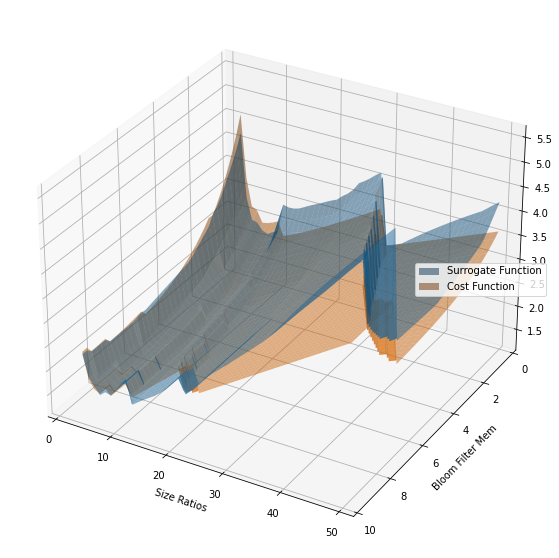

In [32]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': '3d'})
surf1, surf2 = surface_plot(test_df, ax=ax, xlabel='Size Ratios', ylabel='Bloom Filter Mem', legend_on=True)

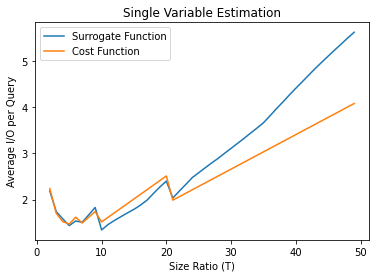

In [34]:
data = test_df.query('h == 9')
x = data['T'].values
y_model, y_analytical = data['model_cost'], data['analytical_cost']

fig, ax = plt.subplots()
ax.plot(x, y_model, label='Surrogate Function')
ax.plot(x, y_analytical, label='Cost Function')
ax.set_xlabel('Size Ratio (T)')
ax.set_ylabel('Average I/O per Query')
ax.set_title('Single Variable Estimation')
ax.legend()
None

MSE = $\frac{1}{n}||model - analytical||^2$

In [35]:
df

,h,T,z0,z1,q,w,B,phi,s,E,...,K_7,K_8,K_9,K_10,K_11,K_12,K_13,K_14,K_15,model_cost
0,4.30,2,0.007,0.312,0.340,0.341,4,1,0.0,1024,...,1,1,1,1,0,0,0,0,0,5.925135
1,2.09,14,0.620,0.021,0.000,0.359,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,2.995541
2,2.09,14,0.620,0.021,0.000,0.359,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,2.647977
3,2.09,14,0.620,0.021,0.000,0.359,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,2.384811
4,2.09,14,0.620,0.021,0.000,0.359,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,2.319205
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9779117,1.54,42,0.257,0.261,0.225,0.258,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,11.243743
9779118,1.54,42,0.257,0.261,0.225,0.258,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,6.418957
9779119,1.54,42,0.257,0.261,0.225,0.258,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,6.650238
9779120,1.54,42,0.257,0.261,0.225,0.258,4,1,0.0,1024,...,0,0,0,0,0,0,0,0,0,9.050331


In [36]:
df.columns

Index(['h', 'T', 'z0', 'z1', 'q', 'w', 'B', 'phi', 's', 'E', 'H', 'N',
       'k_cost', 'K_0', 'K_1', 'K_2', 'K_3', 'K_4', 'K_5', 'K_6', 'K_7', 'K_8',
       'K_9', 'K_10', 'K_11', 'K_12', 'K_13', 'K_14', 'K_15', 'model_cost'],
      dtype='object')